In [1]:
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Load file - UPDATE THIS PATH AS NEEDED
# filepath = "finetune_evals/2025-12-03-23-49-37_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_TriviaMC_n500_comparison.jsonl"
# filepath = "finetune_evals/2025-12-04-00-23-02_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_PopMC_0_difficulty_filtered_test_n500_comparison.jsonl"
filepath = "finetune_evals/2025-12-04-02-49-08_meta-llama-Meta-Llama-3.1-8B-Instruct_llm_metacognition-wbtl9xqu-step-1280-20251203-224144_SimpleMC_n500_comparison.jsonl"

# Read all lines and extract both summaries and sample data
instruct_summary = None
finetuned_summary = None
instruct_samples = []
finetuned_samples = []

with open(filepath, 'r') as f:
    for line in f:
        if line.strip():
            entry = json.loads(line.strip())
            entry_type = entry.get('type', '')
            if entry_type == 'instruct_eval_summary':
                instruct_summary = entry
            elif entry_type == 'finetuned_eval_summary':
                finetuned_summary = entry
            elif entry_type == 'instruct_eval_sample':
                instruct_samples.append(entry)
            elif entry_type == 'finetuned_eval_sample':
                finetuned_samples.append(entry)

# Fallback: if no prefixes found, check for regular eval_summary (backward compatibility)
if instruct_summary is None and finetuned_summary is None:
    with open(filepath, 'r') as f:
        lines = f.readlines()
        last_line = lines[-1].strip()
        eval_summary = json.loads(last_line)
        if eval_summary.get('type') == 'eval_summary':
            finetuned_summary = eval_summary
            print("⚠️  Only found one eval_summary (no prefixes). Assuming it's finetuned model.")
else:
    eval_summary = finetuned_summary  # For backward compatibility with existing code

print("Loaded eval summaries:")
if instruct_summary:
    print(f"  ✓ Instruct (base) model: {instruct_summary.get('n_samples')} samples, Accuracy: {instruct_summary.get('mcq_accuracy', 0):.4f}")
if finetuned_summary:
    print(f"  ✓ Finetuned model: {finetuned_summary.get('n_samples')} samples, Accuracy: {finetuned_summary.get('mcq_accuracy', 0):.4f}")
if not instruct_summary and not finetuned_summary:
    print("  ❌ No eval_summary entries found!")

print(f"\nLoaded sample data:")
print(f"  ✓ Instruct samples: {len(instruct_samples)}")
print(f"  ✓ Finetuned samples: {len(finetuned_samples)}")

# Extract model and dataset info from filepath
def extract_model_dataset_info(filepath):
    """Extract model and dataset names from filepath."""
    path = Path(filepath)
    filename = path.stem  # Get filename without extension
    
    # Parse filename format: {timestamp}_{base_model}_{lora_name}_{dataset_name}_n{num}_comparison.jsonl
    # or: {timestamp}_{base_model}_{lora_name}_{dataset_name}_n{num}.jsonl
    parts = filename.split('_')
    
    # Find base model (starts with 'meta-llama' or similar)
    base_model = None
    lora_name = None
    dataset_name = None
    
    # Look for base model pattern - it's usually a single part like "meta-llama-Meta-Llama-3.1-8B-Instruct"
    # or could be split across parts
    for i, part in enumerate(parts):
        if 'llama' in part.lower() and 'meta' in part.lower():
            # This is likely the full model name in one part
            base_model = part
            break
        elif part.lower() == 'meta' and i + 1 < len(parts) and 'llama' in parts[i+1].lower():
            # Model name might be split - collect parts
            model_parts = [parts[i], parts[i+1]]
            for j in range(i+2, min(i+8, len(parts))):
                # Stop if we hit something that looks like LoRA (metacognition, wbtl, etc.) or dataset
                if any(x in parts[j].lower() for x in ['metacognition', 'wbtl', 'ect', 'step', 'llm']):
                    break
                if parts[j].lower() in ['popmc', 'triviamc', 'simplemc', 'comparison']:
                    break
                if parts[j].startswith('n') and parts[j][1:].isdigit():
                    break
                model_parts.append(parts[j])
            base_model = '-'.join(model_parts)
            break
    
    # Look for dataset name (usually before 'n{num}' or at the end)
    # Common patterns: PopMC, TriviaMC, SimpleMC, etc.
    for i, part in enumerate(parts):
        if part.lower().startswith('popmc') or part.lower().startswith('triviamc') or part.lower().startswith('simplemc'):
            dataset_name = part
            break
        elif 'mc' in part.lower() and len(part) > 3:
            dataset_name = part
            break
    
    # Look for lora name (usually between base model and dataset)
    # It might contain 'llm-metacognition' or similar
    for i, part in enumerate(parts):
        if 'metacognition' in part.lower() or 'ect' in part.lower() or 'wbtl' in part.lower():
            # Lora name might span multiple parts
            lora_parts = []
            for j in range(i, min(i+5, len(parts))):
                if parts[j].startswith('n') and parts[j][1:].isdigit():
                    break
                if parts[j].lower() in ['popmc', 'triviamc', 'simplemc', 'comparison']:
                    break
                lora_parts.append(parts[j])
            if lora_parts:
                lora_name = '-'.join(lora_parts)
            break
    
    # Fallback: try to extract from filename more generically
    if not base_model:
        # Look for parts that look like model names
        for part in parts:
            if 'llama' in part.lower() or 'gpt' in part.lower() or 'instruct' in part.lower():
                base_model = part
                break
    
    if not dataset_name:
        # Try to find dataset name before 'n{num}'
        for i, part in enumerate(parts):
            if part.startswith('n') and part[1:].isdigit():
                if i > 0:
                    dataset_name = parts[i-1]
                break
    
    # Return model name as-is (don't convert to slashes - keep readable format)
    return base_model, lora_name, dataset_name

# Extract model and dataset info from filepath (automatically)
base_model, lora_name, dataset_name = extract_model_dataset_info(filepath)

# Create display strings - YOU CAN EDIT THESE IF NEEDED
if base_model:
    # Keep model name readable (it's already in a good format like "meta-llama-Meta-Llama-3.1-8B-Instruct")
    model_display = base_model
else:
    model_display = "Unknown Model"

if dataset_name:
    dataset_display = dataset_name
else:
    dataset_display = "Unknown Dataset"

# Optional: Override the extracted values if needed
# Uncomment and modify these lines to manually set the values:
# model_display = "Your Model Name Here"
# dataset_display = "Your Dataset Name Here"
# lora_name = "Your LoRA Name Here"  # Optional

print(f"\n📊 Model & Dataset Info (extracted from filename):")
print(f"  Model: {model_display}")
if lora_name:
    print(f"  LoRA Adapter: {lora_name}")
print(f"  Dataset: {dataset_display}")
print(f"\n💡 Tip: You can override these values by editing the variables above.")

# Helper function to add model/dataset info to plots at the top
def add_model_dataset_info(fig, model_display, dataset_display, lora_name=None):
    """Add model and dataset information at the top of a figure in title-sized text."""
    # Create title text
    if lora_name:
        title_text = f"{model_display} (Finetuned) | {dataset_display}"
    else:
        title_text = f"{model_display} | {dataset_display}"
    
    # Add title at the top of the figure, centered
    # Use subplots_adjust to make room at the top
    fig.subplots_adjust(top=0.92)  # Make room for the title
    fig.suptitle(title_text, fontsize=14, fontweight='bold', y=0.98, ha='center')

Loaded eval summaries:
  ✓ Instruct (base) model: 500 samples, Accuracy: 0.2920
  ✓ Finetuned model: 500 samples, Accuracy: 0.3300

Loaded sample data:
  ✓ Instruct samples: 500
  ✓ Finetuned samples: 500

📊 Model & Dataset Info (extracted from filename):
  Model: meta-llama-Meta-Llama-3.1-8B-Instruct
  LoRA Adapter: metacognition-wbtl9xqu-step-1280-20251203-224144
  Dataset: SimpleMC

💡 Tip: You can override these values by editing the variables above.


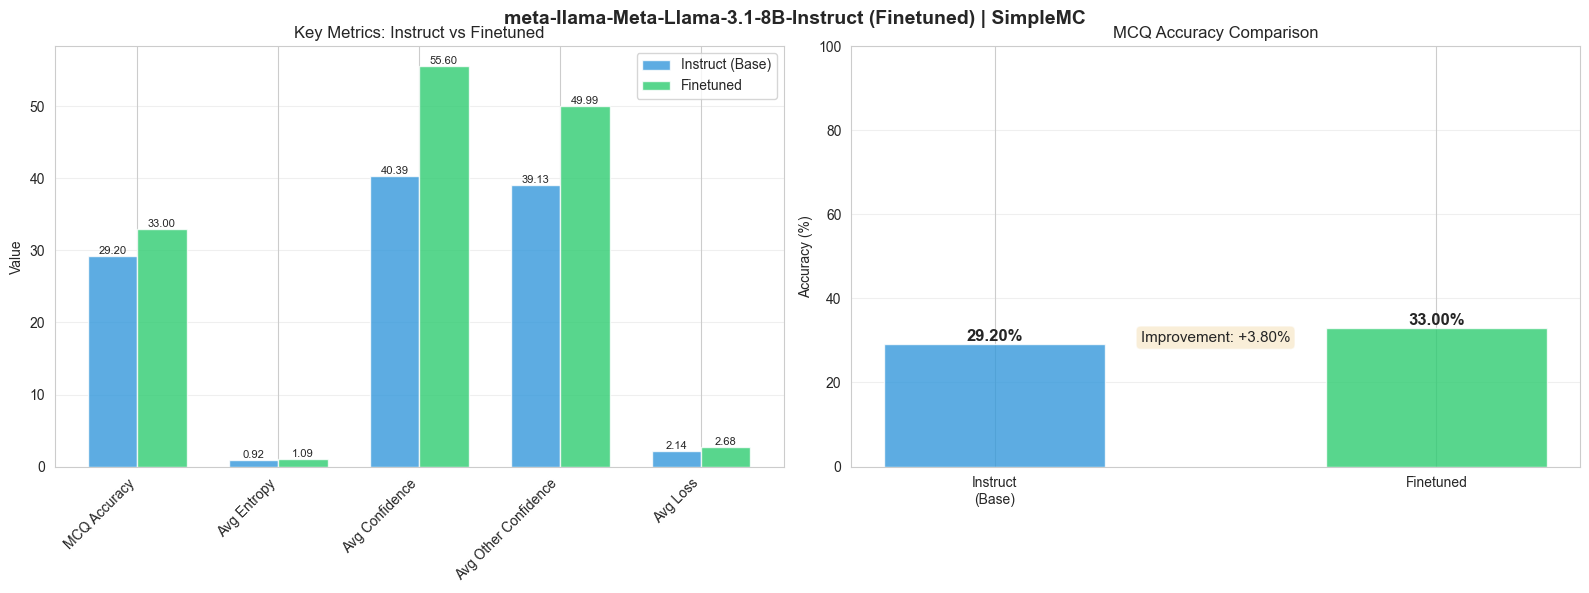

In [2]:
# 1. Main Metrics Comparison (Side-by-Side)
def get_metrics(summary, label):
    if summary is None:
        return None, label
    return {
        'MCQ Accuracy': summary.get('mcq_accuracy', 0) * 100,
        'Avg Entropy': summary.get('avg_entropy', 0),
        'Avg Confidence': summary.get('avg_confidence', 0),
        'Avg Other Confidence': summary.get('avg_other_confidence', 0),
        'Avg Loss': summary.get('avg_loss', 0),
    }, label

instruct_metrics, _ = get_metrics(instruct_summary, 'Instruct')
finetuned_metrics, _ = get_metrics(finetuned_summary, 'Finetuned')

if instruct_summary and finetuned_summary:
    # Side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    metric_names = ['MCQ Accuracy', 'Avg Entropy', 'Avg Confidence', 'Avg Other Confidence', 'Avg Loss']
    x = range(len(metric_names))
    width = 0.35
    
    instruct_vals = [instruct_metrics.get(m, 0) for m in metric_names]
    finetuned_vals = [finetuned_metrics.get(m, 0) for m in metric_names]
    
    ax1 = axes[0]
    ax1.bar([i - width/2 for i in x], instruct_vals, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
    ax1.bar([i + width/2 for i in x], finetuned_vals, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    ax1.set_ylabel('Value')
    ax1.set_title('Key Metrics: Instruct vs Finetuned')
    ax1.set_xticks(x)
    ax1.set_xticklabels(metric_names, rotation=45, ha='right')
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for i, (inst_val, fin_val) in enumerate(zip(instruct_vals, finetuned_vals)):
        ax1.text(i - width/2, inst_val, f'{inst_val:.2f}', ha='center', va='bottom', fontsize=8)
        ax1.text(i + width/2, fin_val, f'{fin_val:.2f}', ha='center', va='bottom', fontsize=8)
    
    # Right: Accuracy comparison
    ax2 = axes[1]
    models = ['Instruct\n(Base)', 'Finetuned']
    accuracies = [instruct_metrics['MCQ Accuracy'], finetuned_metrics['MCQ Accuracy']]
    colors = ['#3498db', '#2ecc71']
    bars = ax2.bar(models, accuracies, color=colors, alpha=0.8, width=0.5)
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('MCQ Accuracy Comparison')
    ax2.set_ylim(0, 100)
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels and improvement
    for bar, acc in zip(bars, accuracies):
        ax2.text(bar.get_x() + bar.get_width()/2., acc,
                f'{acc:.2f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
    
    improvement = finetuned_metrics['MCQ Accuracy'] - instruct_metrics['MCQ Accuracy']
    ax2.text(0.5, max(accuracies) * 0.9, f'Improvement: {improvement:+.2f}%',
            ha='center', fontsize=11, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
else:
    # Single model view (backward compatibility)
    summary = finetuned_summary or instruct_summary
    metrics = {
        'MCQ Accuracy': summary.get('mcq_accuracy', 0) * 100,
        'Avg Entropy': summary.get('avg_entropy', 0),
        'Avg Confidence': summary.get('avg_confidence', 0),
        'Avg Other Confidence': summary.get('avg_other_confidence', 0),
        'Avg Loss': summary.get('avg_loss', 0),
    }
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    ax1 = axes[0]
    bars = ax1.bar(metrics.keys(), metrics.values(), color=['#2ecc71', '#3498db', '#9b59b6', '#e74c3c', '#f39c12'])
    ax1.set_ylabel('Value')
    ax1.set_title('Key Evaluation Metrics')
    ax1.tick_params(axis='x', rotation=45)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.2f}', ha='center', va='bottom', fontsize=9)
    
    ax2 = axes[1]
    ax2.bar(['MCQ Accuracy'], [metrics['MCQ Accuracy']], color='#2ecc71', width=0.3)
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title('Model Accuracy')
    ax2.set_ylim(0, 100)
    ax2.text(0, metrics['MCQ Accuracy'], f'{metrics["MCQ Accuracy"]:.2f}%',
             ha='center', va='bottom', fontsize=12, fontweight='bold')
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


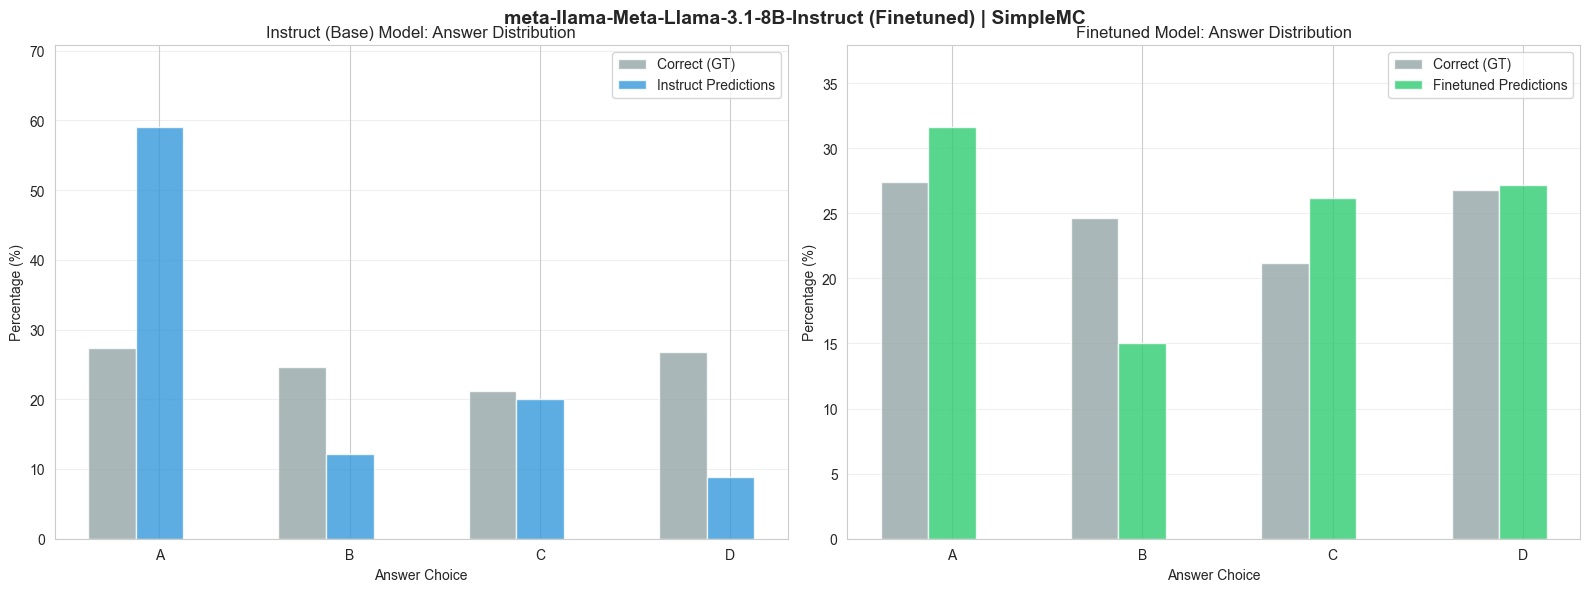

In [3]:
# 2. Answer Distribution Comparison (Side-by-Side)
letters = ['A', 'B', 'C', 'D']

if instruct_summary and finetuned_summary:
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Get distributions
    instruct_pred = instruct_summary.get('predicted_answer_distribution_pct', {})
    finetuned_pred = finetuned_summary.get('predicted_answer_distribution_pct', {})
    correct_dist = finetuned_summary.get('correct_answer_distribution_pct', {})  # Same for both
    
    instruct_pred_vals = [instruct_pred.get(letter, 0) for letter in letters]
    finetuned_pred_vals = [finetuned_pred.get(letter, 0) for letter in letters]
    correct_vals = [correct_dist.get(letter, 0) for letter in letters]
    
    x = range(len(letters))
    width = 0.25
    
    # Left: Instruct model
    ax1 = axes[0]
    ax1.bar([i - width for i in x], correct_vals, width, label='Correct (GT)', color='#95a5a6', alpha=0.8)
    ax1.bar(x, instruct_pred_vals, width, label='Instruct Predictions', color='#3498db', alpha=0.8)
    ax1.set_xlabel('Answer Choice')
    ax1.set_ylabel('Percentage (%)')
    ax1.set_title('Instruct (Base) Model: Answer Distribution')
    ax1.set_xticks(x)
    ax1.set_xticklabels(letters)
    ax1.legend()
    ax1.set_ylim(0, max(max(correct_vals), max(instruct_pred_vals)) * 1.2)
    ax1.grid(axis='y', alpha=0.3)
    
    # Right: Finetuned model
    ax2 = axes[1]
    ax2.bar([i - width for i in x], correct_vals, width, label='Correct (GT)', color='#95a5a6', alpha=0.8)
    ax2.bar(x, finetuned_pred_vals, width, label='Finetuned Predictions', color='#2ecc71', alpha=0.8)
    ax2.set_xlabel('Answer Choice')
    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('Finetuned Model: Answer Distribution')
    ax2.set_xticks(x)
    ax2.set_xticklabels(letters)
    ax2.legend()
    ax2.set_ylim(0, max(max(correct_vals), max(finetuned_pred_vals)) * 1.2)
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
else:
    # Single model view (backward compatibility)
    summary = finetuned_summary or instruct_summary
    correct_dist = summary.get('correct_answer_distribution_pct', {})
    predicted_dist = summary.get('predicted_answer_distribution_pct', {})
    
    correct_values = [correct_dist.get(letter, 0) for letter in letters]
    predicted_values = [predicted_dist.get(letter, 0) for letter in letters]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    x = range(len(letters))
    width = 0.35
    
    ax1 = axes[0]
    ax1.bar([i - width/2 for i in x], correct_values, width, label='Correct (Ground Truth)', color='#3498db', alpha=0.8)
    ax1.bar([i + width/2 for i in x], predicted_values, width, label='Model Predictions', color='#e74c3c', alpha=0.8)
    ax1.set_xlabel('Answer Choice')
    ax1.set_ylabel('Percentage (%)')
    ax1.set_title('Answer Distribution: Correct vs Predicted')
    ax1.set_xticks(x)
    ax1.set_xticklabels(letters)
    ax1.legend()
    ax1.set_ylim(0, max(max(correct_values), max(predicted_values)) * 1.2)
    ax1.grid(axis='y', alpha=0.3)
    
    ax2 = axes[1]
    x_pos = range(len(letters))
    ax2.bar(x_pos, correct_values, label='Correct', color='#3498db', alpha=0.8)
    ax2.bar(x_pos, predicted_values, bottom=correct_values, label='Predicted', color='#e74c3c', alpha=0.8)
    ax2.set_xlabel('Answer Choice')
    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('Answer Distribution: Stacked View')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(letters)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


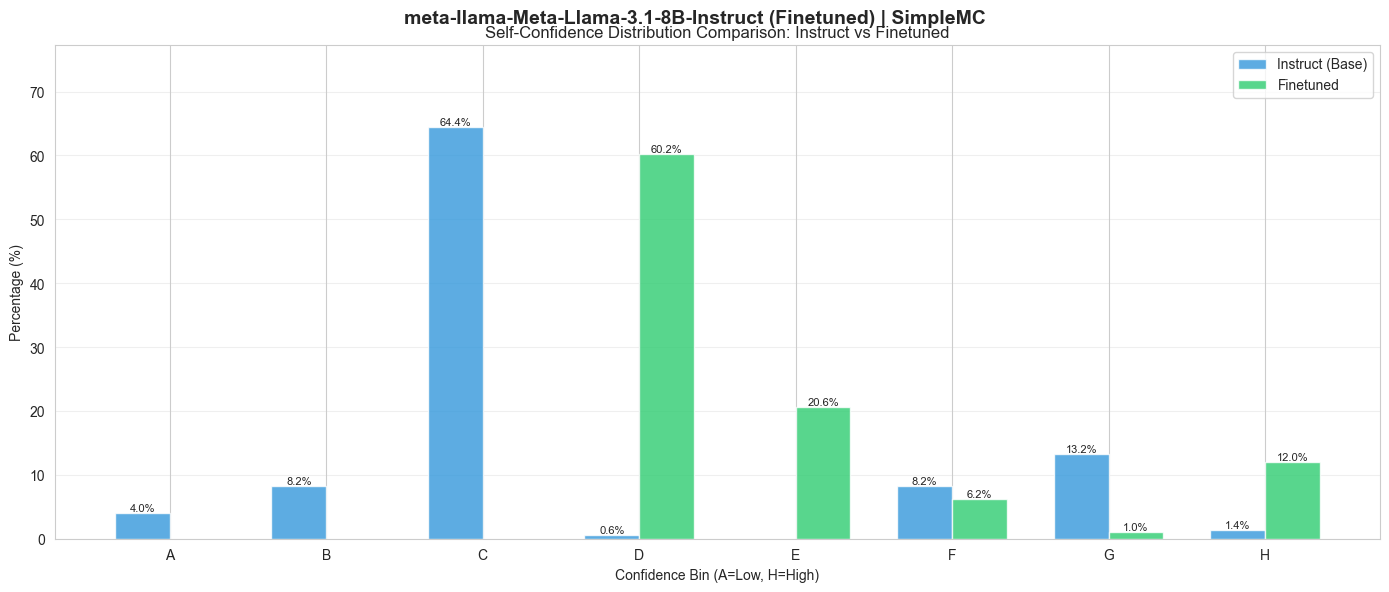

In [4]:
# 3. Self-Confidence Distribution Comparison
conf_bins = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

if instruct_summary and finetuned_summary:
    instruct_conf = instruct_summary.get('predicted_confidence_distribution_pct', {})
    finetuned_conf = finetuned_summary.get('predicted_confidence_distribution_pct', {})
    
    instruct_conf_vals = [instruct_conf.get(bin, 0) for bin in conf_bins]
    finetuned_conf_vals = [finetuned_conf.get(bin, 0) for bin in conf_bins]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    x = range(len(conf_bins))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], instruct_conf_vals, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
    ax.bar([i + width/2 for i in x], finetuned_conf_vals, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    
    ax.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Self-Confidence Distribution Comparison: Instruct vs Finetuned')
    ax.set_xticks(x)
    ax.set_xticklabels(conf_bins)
    ax.legend()
    ax.set_ylim(0, max(max(instruct_conf_vals), max(finetuned_conf_vals)) * 1.2)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels for non-zero values
    for i, (inst_val, fin_val) in enumerate(zip(instruct_conf_vals, finetuned_conf_vals)):
        if inst_val > 0:
            ax.text(i - width/2, inst_val, f'{inst_val:.1f}%', ha='center', va='bottom', fontsize=8)
        if fin_val > 0:
            ax.text(i + width/2, fin_val, f'{fin_val:.1f}%', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
else:
    # Single model view (backward compatibility)
    summary = finetuned_summary or instruct_summary
    conf_dist = summary.get('predicted_confidence_distribution_pct', {})
    conf_values = [conf_dist.get(bin, 0) for bin in conf_bins]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(conf_bins, conf_values, color=plt.cm.viridis([i/len(conf_bins) for i in range(len(conf_bins))]))
    ax.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Self-Confidence Distribution (A-H)')
    ax.set_ylim(0, max(conf_values) * 1.2)
    ax.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, conf_values):
        if val > 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


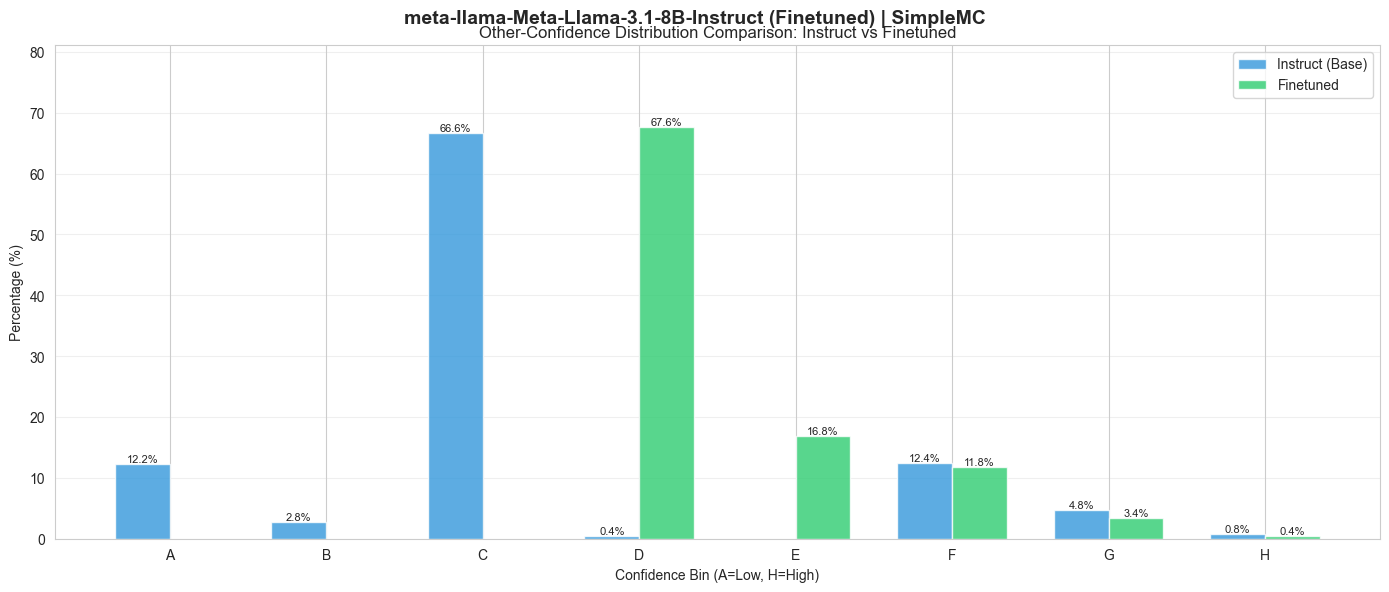

In [5]:
# 4. Other-Confidence Distribution Comparison
if instruct_summary and finetuned_summary:
    instruct_other_conf = instruct_summary.get('predicted_other_confidence_distribution_pct', {})
    finetuned_other_conf = finetuned_summary.get('predicted_other_confidence_distribution_pct', {})
    
    instruct_other_vals = [instruct_other_conf.get(bin, 0) for bin in conf_bins]
    finetuned_other_vals = [finetuned_other_conf.get(bin, 0) for bin in conf_bins]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    x = range(len(conf_bins))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], instruct_other_vals, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
    ax.bar([i + width/2 for i in x], finetuned_other_vals, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    
    ax.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Other-Confidence Distribution Comparison: Instruct vs Finetuned')
    ax.set_xticks(x)
    ax.set_xticklabels(conf_bins)
    ax.legend()
    ax.set_ylim(0, max(max(instruct_other_vals), max(finetuned_other_vals)) * 1.2)
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels for non-zero values
    for i, (inst_val, fin_val) in enumerate(zip(instruct_other_vals, finetuned_other_vals)):
        if inst_val > 0:
            ax.text(i - width/2, inst_val, f'{inst_val:.1f}%', ha='center', va='bottom', fontsize=8)
        if fin_val > 0:
            ax.text(i + width/2, fin_val, f'{fin_val:.1f}%', ha='center', va='bottom', fontsize=8)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
else:
    # Single model view (backward compatibility)
    summary = finetuned_summary or instruct_summary
    other_conf_dist = summary.get('predicted_other_confidence_distribution_pct', {})
    other_conf_values = [other_conf_dist.get(bin, 0) for bin in conf_bins]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(conf_bins, other_conf_values, color=plt.cm.plasma([i/len(conf_bins) for i in range(len(conf_bins))]))
    ax.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Other-Confidence Distribution (A-H)')
    ax.set_ylim(0, max(other_conf_values) * 1.2)
    ax.grid(axis='y', alpha=0.3)
    
    for bar, val in zip(bars, other_conf_values):
        if val > 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{val:.1f}%', ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


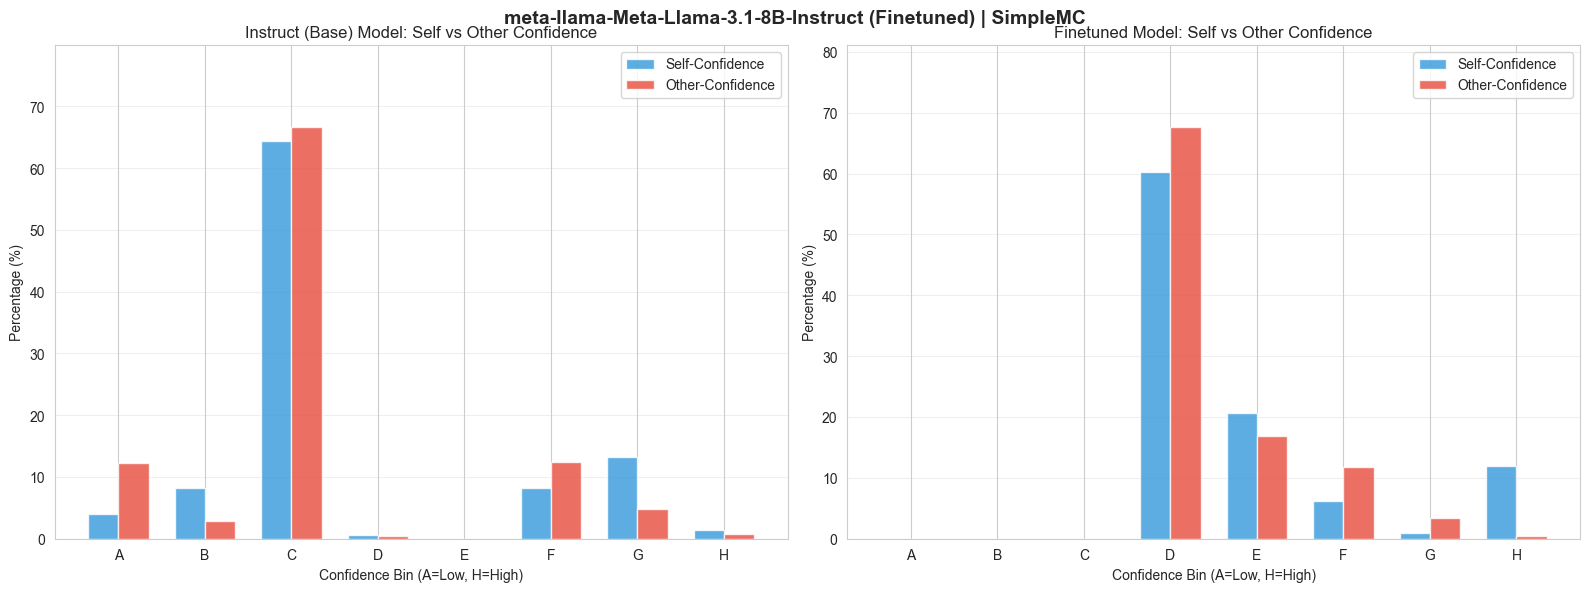

In [6]:
# 5. Self vs Other Confidence Comparison (Side-by-Side)
conf_bins = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']

if instruct_summary and finetuned_summary:
    # Create side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    x = range(len(conf_bins))
    width = 0.35
    
    # Left: Instruct model
    instruct_conf = instruct_summary.get('predicted_confidence_distribution_pct', {})
    instruct_other_conf = instruct_summary.get('predicted_other_confidence_distribution_pct', {})
    instruct_conf_vals = [instruct_conf.get(bin, 0) for bin in conf_bins]
    instruct_other_vals = [instruct_other_conf.get(bin, 0) for bin in conf_bins]
    
    ax1 = axes[0]
    ax1.bar([i - width/2 for i in x], instruct_conf_vals, width, label='Self-Confidence', color='#3498db', alpha=0.8)
    ax1.bar([i + width/2 for i in x], instruct_other_vals, width, label='Other-Confidence', color='#e74c3c', alpha=0.8)
    ax1.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax1.set_ylabel('Percentage (%)')
    ax1.set_title('Instruct (Base) Model: Self vs Other Confidence')
    ax1.set_xticks(x)
    ax1.set_xticklabels(conf_bins)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_ylim(0, max(max(instruct_conf_vals), max(instruct_other_vals)) * 1.2)
    
    # Right: Finetuned model
    finetuned_conf = finetuned_summary.get('predicted_confidence_distribution_pct', {})
    finetuned_other_conf = finetuned_summary.get('predicted_other_confidence_distribution_pct', {})
    finetuned_conf_vals = [finetuned_conf.get(bin, 0) for bin in conf_bins]
    finetuned_other_vals = [finetuned_other_conf.get(bin, 0) for bin in conf_bins]
    
    ax2 = axes[1]
    ax2.bar([i - width/2 for i in x], finetuned_conf_vals, width, label='Self-Confidence', color='#3498db', alpha=0.8)
    ax2.bar([i + width/2 for i in x], finetuned_other_vals, width, label='Other-Confidence', color='#e74c3c', alpha=0.8)
    ax2.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax2.set_ylabel('Percentage (%)')
    ax2.set_title('Finetuned Model: Self vs Other Confidence')
    ax2.set_xticks(x)
    ax2.set_xticklabels(conf_bins)
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(0, max(max(finetuned_conf_vals), max(finetuned_other_vals)) * 1.2)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
elif finetuned_summary:
    # Single model view (backward compatibility)
    finetuned_conf = finetuned_summary.get('predicted_confidence_distribution_pct', {})
    finetuned_other_conf = finetuned_summary.get('predicted_other_confidence_distribution_pct', {})
    finetuned_conf_vals = [finetuned_conf.get(bin, 0) for bin in conf_bins]
    finetuned_other_vals = [finetuned_other_conf.get(bin, 0) for bin in conf_bins]
    
    fig, ax = plt.subplots(figsize=(14, 6))
    x = range(len(conf_bins))
    width = 0.35
    
    ax.bar([i - width/2 for i in x], finetuned_conf_vals, width, label='Self-Confidence', color='#3498db', alpha=0.8)
    ax.bar([i + width/2 for i in x], finetuned_other_vals, width, label='Other-Confidence', color='#e74c3c', alpha=0.8)
    ax.set_xlabel('Confidence Bin (A=Low, H=High)')
    ax.set_ylabel('Percentage (%)')
    ax.set_title('Finetuned Model: Self vs Other Confidence Distribution')
    ax.set_xticks(x)
    ax.set_xticklabels(conf_bins)
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


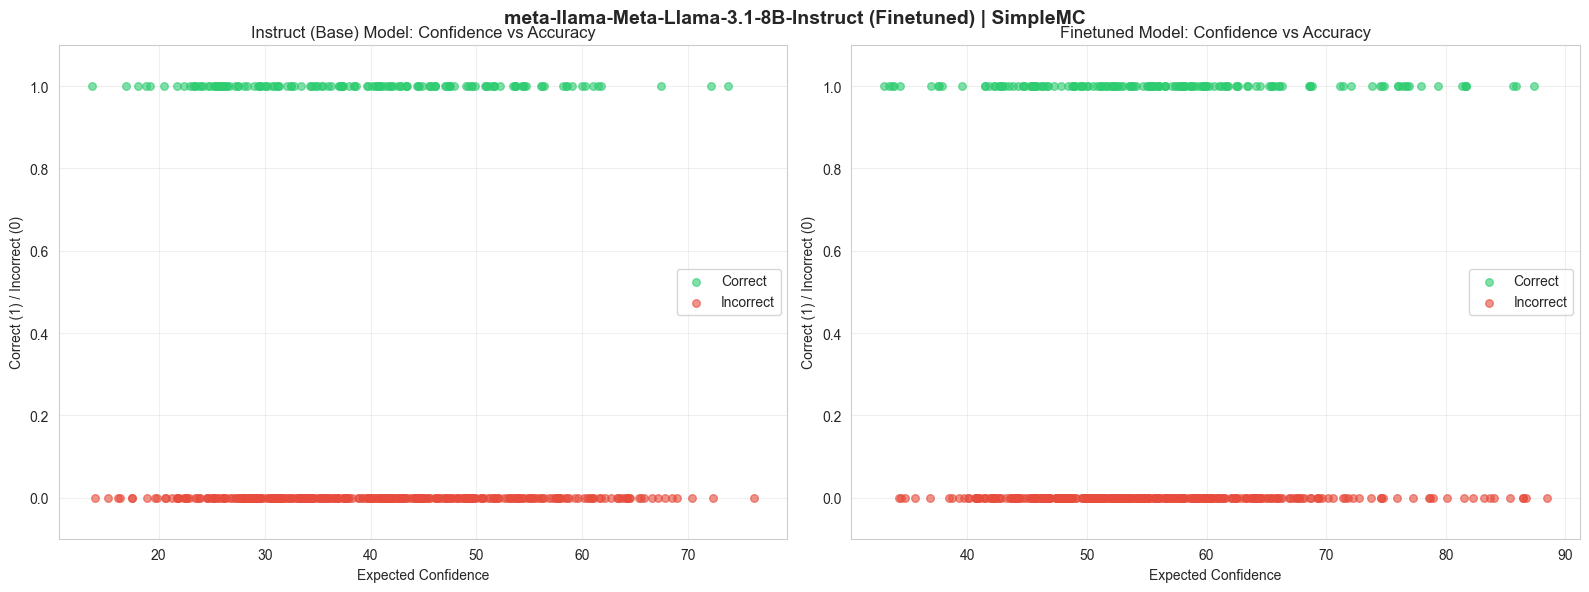

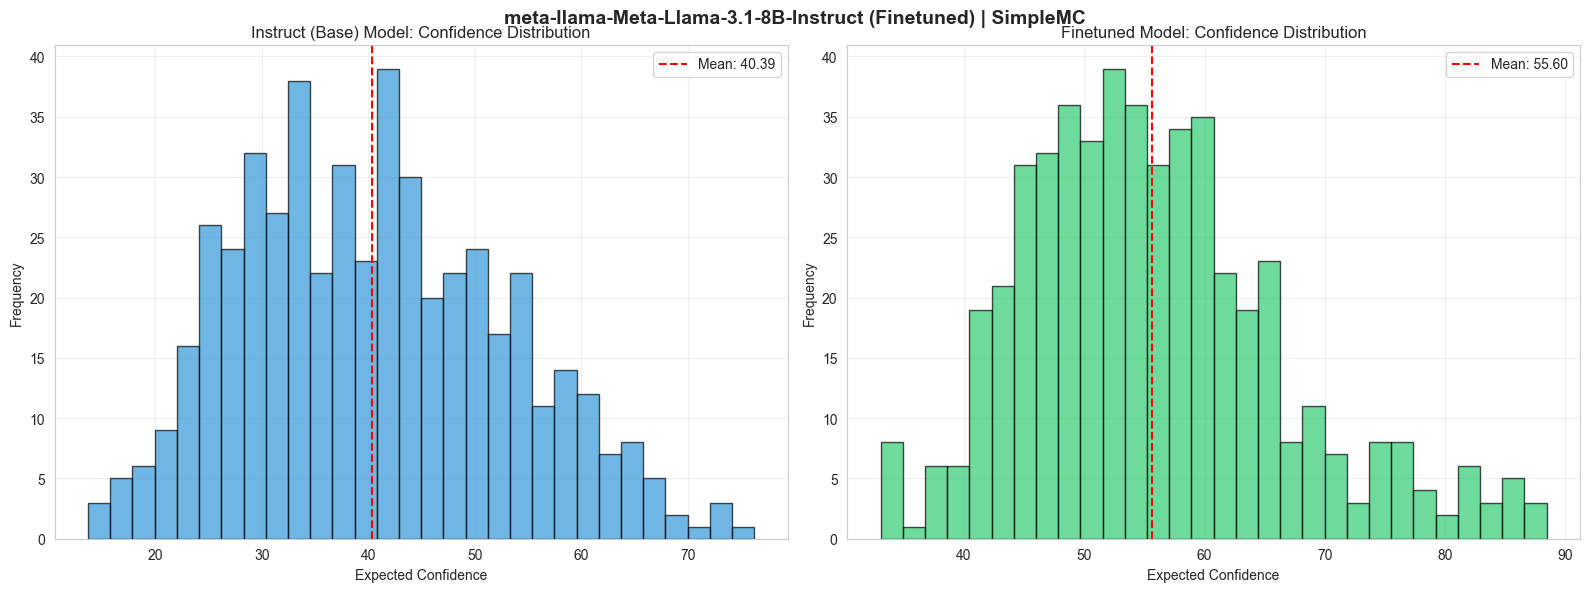

In [7]:
# 6. Confidence vs Accuracy Scatter Comparison
if len(instruct_samples) > 0 and len(finetuned_samples) > 0:
    # Create DataFrames for easier analysis
    instruct_df = pd.DataFrame(instruct_samples)
    finetuned_df = pd.DataFrame(finetuned_samples)
    
    # Match samples by qid for comparison
    instruct_df['is_correct'] = instruct_df['model_answer'] == instruct_df['correct_answer']
    finetuned_df['is_correct'] = finetuned_df['model_answer'] == finetuned_df['correct_answer']
    
    # Merge on qid
    merged = instruct_df[['qid', 'expected_confidence', 'is_correct']].merge(
        finetuned_df[['qid', 'expected_confidence', 'is_correct']], 
        on='qid', 
        suffixes=('_instruct', '_finetuned')
    )
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Instruct model
    ax1 = axes[0]
    correct = merged['is_correct_instruct']
    conf = merged['expected_confidence_instruct']
    ax1.scatter(conf[correct], [1]*correct.sum(), alpha=0.6, color='#2ecc71', label='Correct', s=30)
    ax1.scatter(conf[~correct], [0]*(~correct).sum(), alpha=0.6, color='#e74c3c', label='Incorrect', s=30)
    ax1.set_xlabel('Expected Confidence')
    ax1.set_ylabel('Correct (1) / Incorrect (0)')
    ax1.set_title('Instruct (Base) Model: Confidence vs Accuracy')
    ax1.legend()
    ax1.grid(alpha=0.3)
    ax1.set_ylim(-0.1, 1.1)
    
    # Right: Finetuned model
    ax2 = axes[1]
    correct = merged['is_correct_finetuned']
    conf = merged['expected_confidence_finetuned']
    ax2.scatter(conf[correct], [1]*correct.sum(), alpha=0.6, color='#2ecc71', label='Correct', s=30)
    ax2.scatter(conf[~correct], [0]*(~correct).sum(), alpha=0.6, color='#e74c3c', label='Incorrect', s=30)
    ax2.set_xlabel('Expected Confidence')
    ax2.set_ylabel('Correct (1) / Incorrect (0)')
    ax2.set_title('Finetuned Model: Confidence vs Accuracy')
    ax2.legend()
    ax2.grid(alpha=0.3)
    ax2.set_ylim(-0.1, 1.1)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    # Also show side-by-side confidence distributions
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    ax1 = axes[0]
    ax1.hist(instruct_df['expected_confidence'], bins=30, alpha=0.7, color='#3498db', edgecolor='black')
    ax1.set_xlabel('Expected Confidence')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Instruct (Base) Model: Confidence Distribution')
    ax1.axvline(instruct_df['expected_confidence'].mean(), color='red', linestyle='--', 
                label=f'Mean: {instruct_df["expected_confidence"].mean():.2f}')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    ax2 = axes[1]
    ax2.hist(finetuned_df['expected_confidence'], bins=30, alpha=0.7, color='#2ecc71', edgecolor='black')
    ax2.set_xlabel('Expected Confidence')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Finetuned Model: Confidence Distribution')
    ax2.axvline(finetuned_df['expected_confidence'].mean(), color='red', linestyle='--',
                label=f'Mean: {finetuned_df["expected_confidence"].mean():.2f}')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


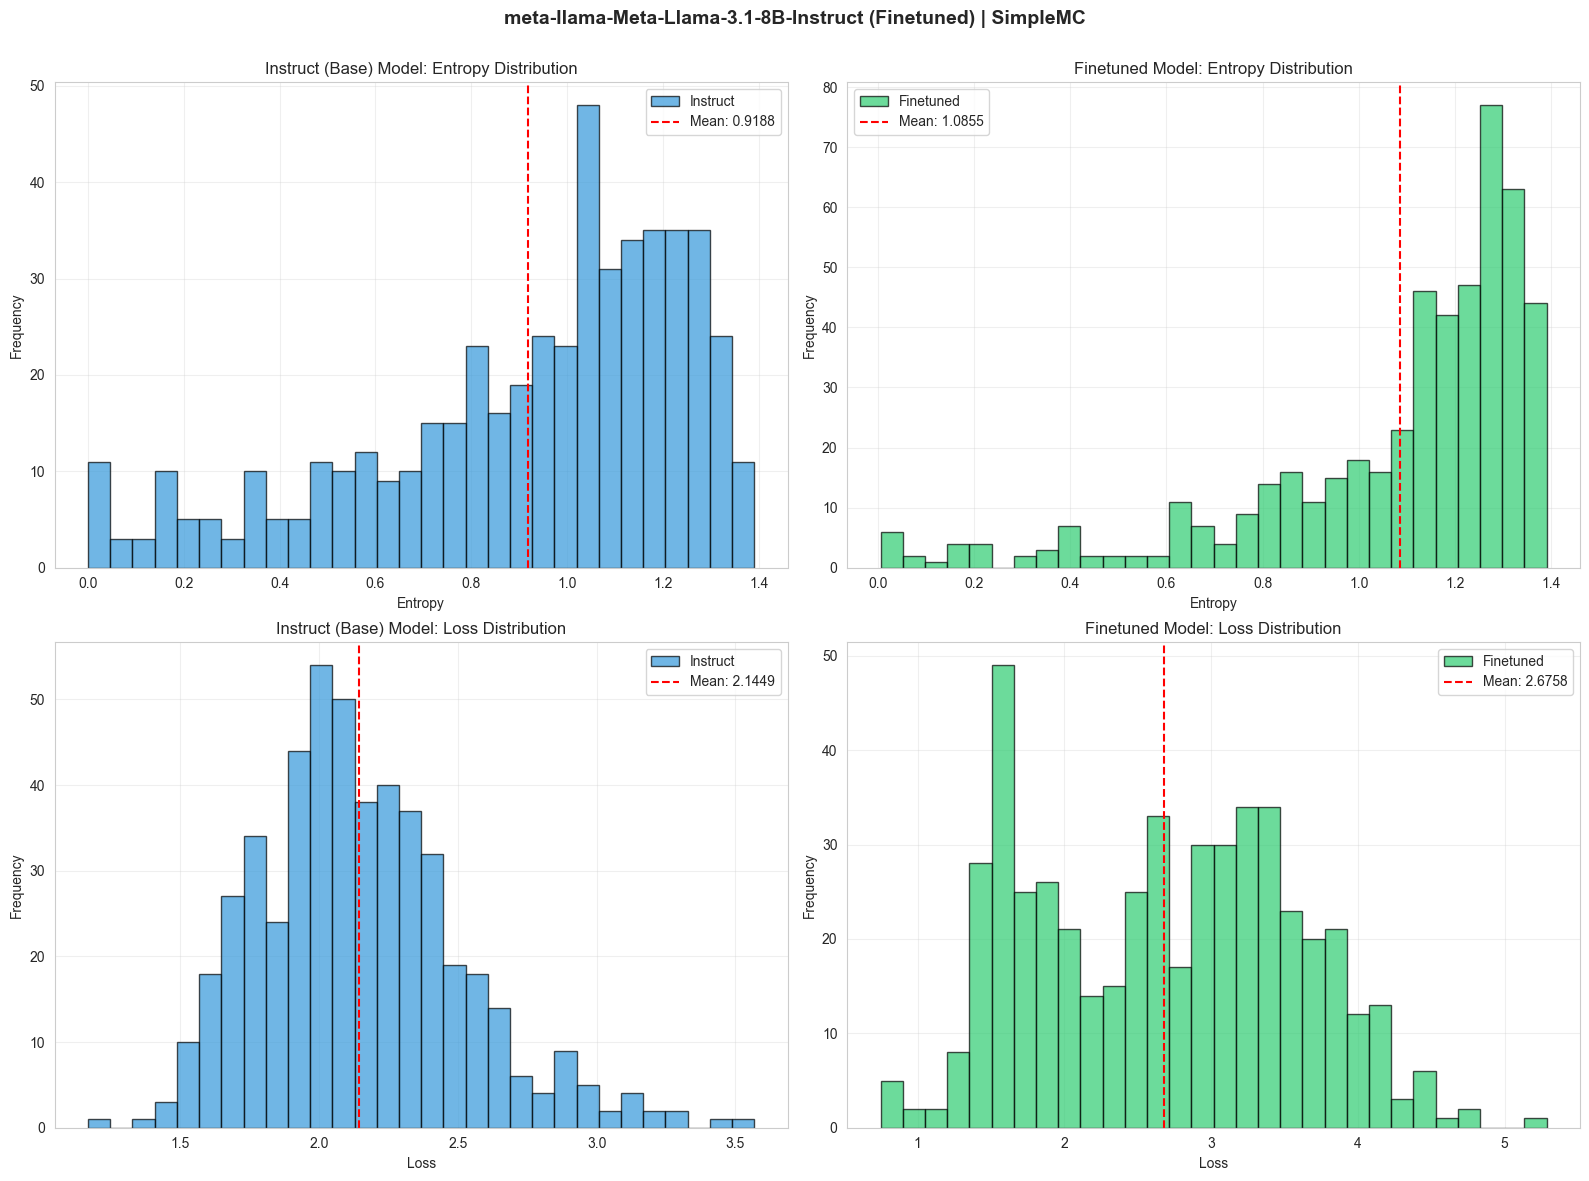

In [8]:
# 7. Entropy and Loss Distributions Comparison
if len(instruct_samples) > 0 and len(finetuned_samples) > 0:
    instruct_df = pd.DataFrame(instruct_samples)
    finetuned_df = pd.DataFrame(finetuned_samples)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Top row: Entropy distributions
    ax1 = axes[0, 0]
    ax1.hist(instruct_df['entropy'], bins=30, alpha=0.7, color='#3498db', edgecolor='black', label='Instruct')
    ax1.axvline(instruct_df['entropy'].mean(), color='red', linestyle='--', 
                label=f'Mean: {instruct_df["entropy"].mean():.4f}')
    ax1.set_xlabel('Entropy')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Instruct (Base) Model: Entropy Distribution')
    ax1.legend()
    ax1.grid(alpha=0.3)
    
    ax2 = axes[0, 1]
    ax2.hist(finetuned_df['entropy'], bins=30, alpha=0.7, color='#2ecc71', edgecolor='black', label='Finetuned')
    ax2.axvline(finetuned_df['entropy'].mean(), color='red', linestyle='--',
                label=f'Mean: {finetuned_df["entropy"].mean():.4f}')
    ax2.set_xlabel('Entropy')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Finetuned Model: Entropy Distribution')
    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Bottom row: Loss distributions
    ax3 = axes[1, 0]
    ax3.hist(instruct_df['loss'], bins=30, alpha=0.7, color='#3498db', edgecolor='black', label='Instruct')
    ax3.axvline(instruct_df['loss'].mean(), color='red', linestyle='--',
                label=f'Mean: {instruct_df["loss"].mean():.4f}')
    ax3.set_xlabel('Loss')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Instruct (Base) Model: Loss Distribution')
    ax3.legend()
    ax3.grid(alpha=0.3)
    
    ax4 = axes[1, 1]
    ax4.hist(finetuned_df['loss'], bins=30, alpha=0.7, color='#2ecc71', edgecolor='black', label='Finetuned')
    ax4.axvline(finetuned_df['loss'].mean(), color='red', linestyle='--',
                label=f'Mean: {finetuned_df["loss"].mean():.4f}')
    ax4.set_xlabel('Loss')
    ax4.set_ylabel('Frequency')
    ax4.set_title('Finetuned Model: Loss Distribution')
    ax4.legend()
    ax4.grid(alpha=0.3)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()


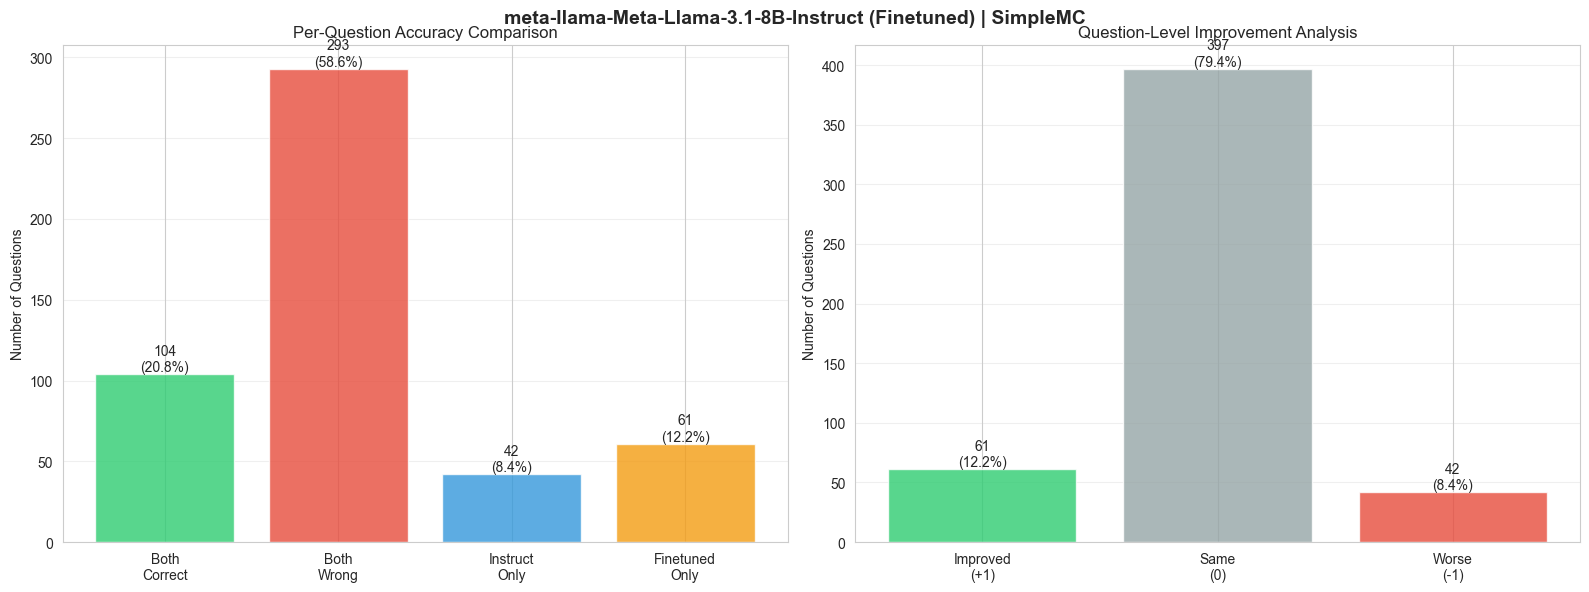


📊 Per-Question Analysis:
   Total questions: 500
   Both correct: 104 (20.8%)
   Both wrong: 293 (58.6%)
   Improved (wrong→correct): 61 (12.2%)
   Regressed (correct→wrong): 42 (8.4%)
   Net improvement: 19 questions


In [9]:
# 8. Per-Question Accuracy Comparison
if len(instruct_samples) > 0 and len(finetuned_samples) > 0:
    instruct_df = pd.DataFrame(instruct_samples)
    finetuned_df = pd.DataFrame(finetuned_samples)
    
    # Match samples by qid
    merged = instruct_df[['qid', 'model_answer', 'correct_answer']].merge(
        finetuned_df[['qid', 'model_answer', 'correct_answer']], 
        on='qid', 
        suffixes=('_instruct', '_finetuned')
    )
    
    merged['correct_instruct'] = merged['model_answer_instruct'] == merged['correct_answer_instruct']
    merged['correct_finetuned'] = merged['model_answer_finetuned'] == merged['correct_answer_finetuned']
    
    # Categorize questions
    both_correct = (merged['correct_instruct'] & merged['correct_finetuned']).sum()
    both_wrong = ((~merged['correct_instruct']) & (~merged['correct_finetuned'])).sum()
    instruct_only = (merged['correct_instruct'] & (~merged['correct_finetuned'])).sum()
    finetuned_only = ((~merged['correct_instruct']) & merged['correct_finetuned']).sum()
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left: Question outcome categories
    ax1 = axes[0]
    categories = ['Both\nCorrect', 'Both\nWrong', 'Instruct\nOnly', 'Finetuned\nOnly']
    counts = [both_correct, both_wrong, instruct_only, finetuned_only]
    colors = ['#2ecc71', '#e74c3c', '#3498db', '#f39c12']
    bars = ax1.bar(categories, counts, color=colors, alpha=0.8)
    ax1.set_ylabel('Number of Questions')
    ax1.set_title('Per-Question Accuracy Comparison')
    ax1.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\n({count/len(merged)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10)
    
    # Right: Improvement breakdown
    ax2 = axes[1]
    improvement_categories = ['Improved\n(+1)', 'Same\n(0)', 'Worse\n(-1)']
    improvement_counts = [
        finetuned_only,  # Improved: wrong -> correct
        both_correct + both_wrong,  # Same: both correct or both wrong
        instruct_only  # Worse: correct -> wrong
    ]
    improvement_colors = ['#2ecc71', '#95a5a6', '#e74c3c']
    bars2 = ax2.bar(improvement_categories, improvement_counts, color=improvement_colors, alpha=0.8)
    ax2.set_ylabel('Number of Questions')
    ax2.set_title('Question-Level Improvement Analysis')
    ax2.grid(axis='y', alpha=0.3)
    
    # Add value labels
    for bar, count in zip(bars2, improvement_counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}\n({count/len(merged)*100:.1f}%)',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    print(f"\n📊 Per-Question Analysis:")
    print(f"   Total questions: {len(merged)}")
    print(f"   Both correct: {both_correct} ({both_correct/len(merged)*100:.1f}%)")
    print(f"   Both wrong: {both_wrong} ({both_wrong/len(merged)*100:.1f}%)")
    print(f"   Improved (wrong→correct): {finetuned_only} ({finetuned_only/len(merged)*100:.1f}%)")
    print(f"   Regressed (correct→wrong): {instruct_only} ({instruct_only/len(merged)*100:.1f}%)")
    print(f"   Net improvement: {finetuned_only - instruct_only} questions")


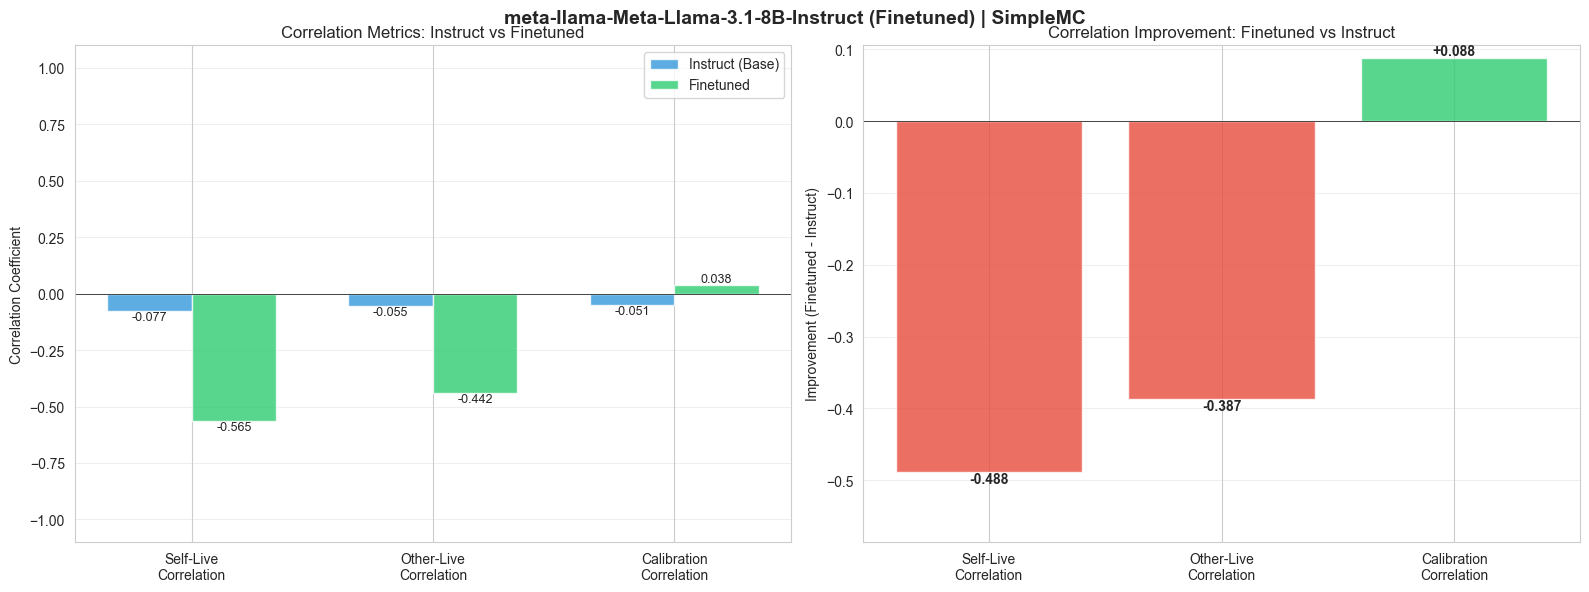


CORRELATION METRICS COMPARISON
Self-Live Correlation (Entropy ↔ Self-Confidence):
  Instruct (Base): -0.0770
  Finetuned:       -0.5652
  Improvement:     -0.4883

Other-Live Correlation (Entropy ↔ Other-Confidence):
  Instruct (Base): -0.0548
  Finetuned:       -0.4418
  Improvement:     -0.3870

Calibration Correlation (Confidence ↔ Correctness):
  Instruct (Base): -0.0506
  Finetuned:       0.0377
  Improvement:     +0.0882

📊 Interpretation:
  • Self-Live Correlation: How well the model's uncertainty (entropy) aligns with
    its own confidence predictions. Higher = better self-awareness.
  • Other-Live Correlation: How well the model's uncertainty aligns with its
    predictions about others' accuracy. Higher = better understanding of difficulty.
  • Calibration Correlation: How well confidence predicts actual correctness.
    Higher = better calibrated confidence.


In [10]:
# 10. Correlation Metrics Comparison (Self-Live and Other-Live Correlations)
# Compute correlations from sample data
from scipy.stats import pearsonr

if len(instruct_samples) > 0 and len(finetuned_samples) > 0:
    # Extract data for instruct model
    instruct_entropy = np.array([s.get('entropy', 0) for s in instruct_samples])
    instruct_conf = np.array([s.get('expected_confidence', 0) for s in instruct_samples])
    instruct_other_conf = np.array([s.get('expected_other_confidence', 0) for s in instruct_samples])
    instruct_correct = np.array([1.0 if s.get('model_answer') == s.get('correct_answer') else 0.0 for s in instruct_samples])
    
    # Extract data for finetuned model
    finetuned_entropy = np.array([s.get('entropy', 0) for s in finetuned_samples])
    finetuned_conf = np.array([s.get('expected_confidence', 0) for s in finetuned_samples])
    finetuned_other_conf = np.array([s.get('expected_other_confidence', 0) for s in finetuned_samples])
    finetuned_correct = np.array([1.0 if s.get('model_answer') == s.get('correct_answer') else 0.0 for s in finetuned_samples])
    
    # Compute self_live_corr: correlation between entropy and self-confidence
    try:
        if len(instruct_entropy) > 1 and np.std(instruct_conf) > 0.001:
            instruct_self_live, _ = pearsonr(instruct_entropy, instruct_conf)
        else:
            instruct_self_live = 0.0
    except:
        instruct_self_live = 0.0
    
    try:
        if len(finetuned_entropy) > 1 and np.std(finetuned_conf) > 0.001:
            finetuned_self_live, _ = pearsonr(finetuned_entropy, finetuned_conf)
        else:
            finetuned_self_live = 0.0
    except:
        finetuned_self_live = 0.0
    
    # Compute other_live_corr: correlation between entropy and other-confidence
    try:
        if len(instruct_entropy) > 1 and np.std(instruct_other_conf) > 0.001:
            instruct_other_live, _ = pearsonr(instruct_entropy, instruct_other_conf)
        else:
            instruct_other_live = 0.0
    except:
        instruct_other_live = 0.0
    
    try:
        if len(finetuned_entropy) > 1 and np.std(finetuned_other_conf) > 0.001:
            finetuned_other_live, _ = pearsonr(finetuned_entropy, finetuned_other_conf)
        else:
            finetuned_other_live = 0.0
    except:
        finetuned_other_live = 0.0
    
    # Compute calibration_corr: correlation between confidence and correctness
    try:
        if len(instruct_conf) > 1 and np.std(instruct_conf) > 0.001:
            instruct_calibration, _ = pearsonr(instruct_conf, instruct_correct)
        else:
            instruct_calibration = 0.0
    except:
        instruct_calibration = 0.0
    
    try:
        if len(finetuned_conf) > 1 and np.std(finetuned_conf) > 0.001:
            finetuned_calibration, _ = pearsonr(finetuned_conf, finetuned_correct)
        else:
            finetuned_calibration = 0.0
    except:
        finetuned_calibration = 0.0
    
    # Create side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    correlation_names = ['Self-Live\nCorrelation', 'Other-Live\nCorrelation', 'Calibration\nCorrelation']
    x = range(len(correlation_names))
    width = 0.35
    
    instruct_corrs = [instruct_self_live, instruct_other_live, instruct_calibration]
    finetuned_corrs = [finetuned_self_live, finetuned_other_live, finetuned_calibration]
    
    # Left: Bar chart comparison
    ax1 = axes[0]
    bars1 = ax1.bar([i - width/2 for i in x], instruct_corrs, width, label='Instruct (Base)', color='#3498db', alpha=0.8)
    bars2 = ax1.bar([i + width/2 for i in x], finetuned_corrs, width, label='Finetuned', color='#2ecc71', alpha=0.8)
    ax1.set_ylabel('Correlation Coefficient')
    ax1.set_title('Correlation Metrics: Instruct vs Finetuned')
    ax1.set_xticks(x)
    ax1.set_xticklabels(correlation_names)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    ax1.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax1.set_ylim(-1.1, 1.1)
    
    # Add value labels
    for i, (inst_val, fin_val) in enumerate(zip(instruct_corrs, finetuned_corrs)):
        ax1.text(i - width/2, inst_val, f'{inst_val:.3f}', ha='center', 
                va='bottom' if inst_val >= 0 else 'top', fontsize=9)
        ax1.text(i + width/2, fin_val, f'{fin_val:.3f}', ha='center',
                va='bottom' if fin_val >= 0 else 'top', fontsize=9)
    
    # Right: Improvement visualization
    ax2 = axes[1]
    improvements = [finetuned_self_live - instruct_self_live,
                   finetuned_other_live - instruct_other_live,
                   finetuned_calibration - instruct_calibration]
    colors = ['#2ecc71' if imp >= 0 else '#e74c3c' for imp in improvements]
    bars = ax2.bar(correlation_names, improvements, color=colors, alpha=0.8)
    ax2.set_ylabel('Improvement (Finetuned - Instruct)')
    ax2.set_title('Correlation Improvement: Finetuned vs Instruct')
    ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(min(improvements) * 1.2, max(improvements) * 1.2)
    
    # Add value labels
    for bar, imp in zip(bars, improvements):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{imp:+.3f}', ha='center',
                va='bottom' if imp >= 0 else 'top', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    # Print detailed comparison
    print("\n" + "="*80)
    print("CORRELATION METRICS COMPARISON")
    print("="*80)
    print(f"Self-Live Correlation (Entropy ↔ Self-Confidence):")
    print(f"  Instruct (Base): {instruct_self_live:.4f}")
    print(f"  Finetuned:       {finetuned_self_live:.4f}")
    print(f"  Improvement:     {finetuned_self_live - instruct_self_live:+.4f}")
    print()
    print(f"Other-Live Correlation (Entropy ↔ Other-Confidence):")
    print(f"  Instruct (Base): {instruct_other_live:.4f}")
    print(f"  Finetuned:       {finetuned_other_live:.4f}")
    print(f"  Improvement:     {finetuned_other_live - instruct_other_live:+.4f}")
    print()
    print(f"Calibration Correlation (Confidence ↔ Correctness):")
    print(f"  Instruct (Base): {instruct_calibration:.4f}")
    print(f"  Finetuned:       {finetuned_calibration:.4f}")
    print(f"  Improvement:     {finetuned_calibration - instruct_calibration:+.4f}")
    print("="*80)
    
    # Interpretation
    print("\n📊 Interpretation:")
    print("  • Self-Live Correlation: How well the model's uncertainty (entropy) aligns with")
    print("    its own confidence predictions. Higher = better self-awareness.")
    print("  • Other-Live Correlation: How well the model's uncertainty aligns with its")
    print("    predictions about others' accuracy. Higher = better understanding of difficulty.")
    print("  • Calibration Correlation: How well confidence predicts actual correctness.")
    print("    Higher = better calibrated confidence.")
elif len(finetuned_samples) > 0:
    # Single model view (backward compatibility) - compute from samples
    finetuned_entropy = np.array([s.get('entropy', 0) for s in finetuned_samples])
    finetuned_conf = np.array([s.get('expected_confidence', 0) for s in finetuned_samples])
    finetuned_other_conf = np.array([s.get('expected_other_confidence', 0) for s in finetuned_samples])
    finetuned_correct = np.array([1.0 if s.get('model_answer') == s.get('correct_answer') else 0.0 for s in finetuned_samples])
    
    try:
        if len(finetuned_entropy) > 1 and np.std(finetuned_conf) > 0.001:
            finetuned_self_live, _ = pearsonr(finetuned_entropy, finetuned_conf)
        else:
            finetuned_self_live = 0.0
    except:
        finetuned_self_live = 0.0
    
    try:
        if len(finetuned_entropy) > 1 and np.std(finetuned_other_conf) > 0.001:
            finetuned_other_live, _ = pearsonr(finetuned_entropy, finetuned_other_conf)
        else:
            finetuned_other_live = 0.0
    except:
        finetuned_other_live = 0.0
    
    try:
        if len(finetuned_conf) > 1 and np.std(finetuned_conf) > 0.001:
            finetuned_calibration, _ = pearsonr(finetuned_conf, finetuned_correct)
        else:
            finetuned_calibration = 0.0
    except:
        finetuned_calibration = 0.0
    
    fig, ax = plt.subplots(figsize=(12, 6))
    correlation_names = ['Self-Live\nCorrelation', 'Other-Live\nCorrelation', 'Calibration\nCorrelation']
    corrs = [finetuned_self_live, finetuned_other_live, finetuned_calibration]
    bars = ax.bar(correlation_names, corrs, color=['#3498db', '#2ecc71', '#9b59b6'], alpha=0.8)
    ax.set_ylabel('Correlation Coefficient')
    ax.set_title('Correlation Metrics')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(-1.1, 1.1)
    
    for bar, corr in zip(bars, corrs):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{corr:.3f}', ha='center',
                va='bottom' if corr >= 0 else 'top', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    add_model_dataset_info(fig, model_display, dataset_display, lora_name)
    plt.show()
    
    print(f"\nCorrelation Metrics:")
    print(f"  Self-Live Correlation: {finetuned_self_live:.4f}")
    print(f"  Other-Live Correlation: {finetuned_other_live:.4f}")
    print(f"  Calibration Correlation: {finetuned_calibration:.4f}")


In [11]:
# 9. Summary Statistics Comparison Table
if instruct_summary and finetuned_summary:
    comparison_data = {
        'Metric': [
            'MCQ Accuracy (%)',
            'Average Entropy',
            'Average Self-Confidence',
            'Average Other-Confidence',
            'Average Loss',
            'Number of Samples'
        ],
        'Instruct (Base)': [
            f"{instruct_summary.get('mcq_accuracy', 0) * 100:.2f}%",
            f"{instruct_summary.get('avg_entropy', 0):.4f}",
            f"{instruct_summary.get('avg_confidence', 0):.2f}",
            f"{instruct_summary.get('avg_other_confidence', 0):.2f}",
            f"{instruct_summary.get('avg_loss', 0):.4f}",
            f"{instruct_summary.get('n_samples', 0)}"
        ],
        'Finetuned': [
            f"{finetuned_summary.get('mcq_accuracy', 0) * 100:.2f}%",
            f"{finetuned_summary.get('avg_entropy', 0):.4f}",
            f"{finetuned_summary.get('avg_confidence', 0):.2f}",
            f"{finetuned_summary.get('avg_other_confidence', 0):.2f}",
            f"{finetuned_summary.get('avg_loss', 0):.4f}",
            f"{finetuned_summary.get('n_samples', 0)}"
        ],
        'Improvement': [
            f"{((finetuned_summary.get('mcq_accuracy', 0) - instruct_summary.get('mcq_accuracy', 0)) * 100):+.2f}%",
            f"{(finetuned_summary.get('avg_entropy', 0) - instruct_summary.get('avg_entropy', 0)):+.4f}",
            f"{(finetuned_summary.get('avg_confidence', 0) - instruct_summary.get('avg_confidence', 0)):+.2f}",
            f"{(finetuned_summary.get('avg_other_confidence', 0) - instruct_summary.get('avg_other_confidence', 0)):+.2f}",
            f"{(finetuned_summary.get('avg_loss', 0) - instruct_summary.get('avg_loss', 0)):+.4f}",
            f"{finetuned_summary.get('n_samples', 0) - instruct_summary.get('n_samples', 0):+d}"
        ]
    }
    
    df = pd.DataFrame(comparison_data)
    print("\n" + "="*80)
    print("EVALUATION SUMMARY COMPARISON")
    print("="*80)
    print(df.to_string(index=False))
    print("="*80)
    
    # Highlight key improvements
    acc_improvement = (finetuned_summary.get('mcq_accuracy', 0) - instruct_summary.get('mcq_accuracy', 0)) * 100
    print(f"\n🎯 Key Improvement: Accuracy increased by {acc_improvement:+.2f}%")
    print(f"   Instruct: {instruct_summary.get('mcq_accuracy', 0) * 100:.2f}% → Finetuned: {finetuned_summary.get('mcq_accuracy', 0) * 100:.2f}%")
else:
    # Single model view (backward compatibility)
    summary = finetuned_summary or instruct_summary
    summary_data = {
        'Metric': [
            'MCQ Accuracy',
            'Average Entropy',
            'Average Self-Confidence',
            'Average Other-Confidence',
            'Average Loss',
            'Number of Samples'
        ],
        'Value': [
            f"{summary.get('mcq_accuracy', 0) * 100:.2f}%",
            f"{summary.get('avg_entropy', 0):.4f}",
            f"{summary.get('avg_confidence', 0):.2f}",
            f"{summary.get('avg_other_confidence', 0):.2f}",
            f"{summary.get('avg_loss', 0):.4f}",
            f"{summary.get('n_samples', 0)}"
        ]
    }
    
    df = pd.DataFrame(summary_data)
    print("\n" + "="*60)
    print("EVALUATION SUMMARY")
    print("="*60)
    print(df.to_string(index=False))
    print("="*60)



EVALUATION SUMMARY COMPARISON
                  Metric Instruct (Base) Finetuned Improvement
        MCQ Accuracy (%)          29.20%    33.00%      +3.80%
         Average Entropy          0.9188    1.0855     +0.1667
 Average Self-Confidence           40.39     55.60      +15.21
Average Other-Confidence           39.13     49.99      +10.86
            Average Loss          2.1449    2.6758     +0.5309
       Number of Samples             500       500          +0

🎯 Key Improvement: Accuracy increased by +3.80%
   Instruct: 29.20% → Finetuned: 33.00%
